Playing with Eigen Faces
===

In this tutorial article, we want to learn how to combine landmark points together in order to create new faces. This process is used in developing Active Shape Model (ASM), which is a technique for detecting landmarks (key facial points) on a face image. This is an example of landmark points on a face image:


<img src="figs/asm-example.jpg"></img>

In ASM, first you start training a model using a set of pre-annotated faces, where a fixed number of landmarks are given, and the goal is to automatically identify landmarks on a new face image. 

The goal of this tutorial is to walk you through the first step of ASM training. We have a dataset of images and their landmark points. We will 1) align all the landmarks, 2) compute the mean face 3) create a model for generating new faces using eigen faces.

For this tutorial, we use MUCT database: <a href="www.milbo.org/muct">www.milbo.org/muct</a> which contains 3755 faces with manually landmarked 76 points for each face. 

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

import pandas

After downloading the dataset, unzip the landmarks, and use a file named `muct76.csv`.

In [2]:
df = pandas.read_csv('muct76.csv', header=0, usecols=np.arange(2,154), dtype=float)

df.head()

,x00,y00,x01,y01,x02,y02,x03,y03,x04,y04,...,x71,y71,x72,y72,x73,y73,x74,y74,x75,y75
0,-39.0,-28.0,-39.0,-61.0,-38.0,-88.0,-31.0,-115.0,-16.0,-141.0,...,-4.5,-28.5,98.0,-13.5,84.0,-15.5,86.0,-22.5,100.0,-20.5
1,-78.0,-37.0,-83.0,-67.0,-80.0,-98.0,-73.0,-126.0,-58.0,-157.0,...,-37.5,-39.0,65.5,-26.0,51.5,-28.0,52.0,-34.5,66.0,-32.5
2,-28.0,-32.0,-37.0,-60.0,-40.0,-87.0,-29.0,-119.0,-16.0,-159.0,...,17.5,-35.0,104.5,-23.5,94.0,-25.0,95.0,-31.0,105.5,-29.5
3,-83.0,4.0,-85.0,-28.0,-86.0,-53.0,-81.0,-87.0,-68.0,-115.0,...,-48.0,1.0,55.5,8.5,40.0,7.0,42.0,0.0,57.5,1.5
4,-39.0,-53.0,-40.0,-88.0,-37.0,-113.0,-27.0,-143.0,-14.0,-161.0,...,-3.0,-57.5,95.5,-46.5,82.0,-49.0,84.5,-55.0,98.0,-52.5


The df contains both $x$ and $y$ coordinates of landmark points. There are 3755 images in the dataset, but the reverse (mirrored) images are also considered here, so total we have 7510 rows. Next, let us split the $x$, $y$ coordinates into separate numpy arrays for convinience.

In [4]:
X = df.iloc[:, ::2].values
Y = df.iloc[:, 1::2].values

print(X.shape, Y.shape)

(7510, 76) (7510, 76)


Now, let us visualize it to get more familar with the data. We can plot the landmarks for one image using matplotlib. Landmarks identify eyebrows, eyes, face boundary, nose, upper and lower lips. These facial points are exteremly useful for a lot of computer vision applications. 

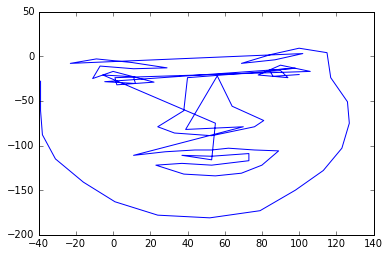

In [5]:
plt.plot(X[0,:], Y[0,:])
plt.show()

## Step 1: Computing the mean face

In order to compute the mean-face, we need to align all faces together. Typically for alignment we need to do three forms of transformation: linear translation, scaling and rotation. Assuming that all the images have straight pose, we can skip the rotation. The general formula for transformation is the following

$$\mathrm T\displaystyle \left(\begin{array}{c}x\\y\end{array}\right) = s \left[ \begin{array}{cc} \cos \theta & \sin \theta \\ -\sin \theta & \cos \theta \end{array}\right]  \left( \begin{array}{c}x \\ y \end{array}\right) + \left(\begin{array}{c} x_{translate} \\ y_{translate}  \end{array} \right) $$

Where, $s$ is the scaling factor, $\theta$ is the rotation angle, and $x_{translate}$ and $y_{translate}$ are the translations in $x, y$ coordinates.

We want to do two forms of transformation: linear translation, and scaling.




### Mean centering all faces

For mean centering, first, we need to find the center of each face, i.e.  the mean of all $x$ and $y$ coordinates. Then, we can apply a linear translation so that the center of each face is located at coordinate $(0, 0)$. This way, we can overlap all the images.

In [6]:
xmeans = np.mean(X, axis=1)
ymeans = np.mean(Y, axis=1)

xmeans.shape

(7510,)

In [7]:
## mean-centering each image

X = (X.T - xmeans).T
Y = (Y.T - ymeans).T

### Scaling faces
For scaling, we need to normalize the faces to a fixed value. One idea is to scale based on the interpupillary distance (IPD), the distance between the center of pupils, to a fixed value, while keeping the same aspect ratio in the original face. The center of pupils are marked as landmark indexed at 31 and 36.



In [9]:
for i, (fx, fy) in enumerate(zip(X, Y)):
    interpupils_dist = np.abs(fx[31] - fx[36])
    
    X[i,:] = X[i,:] * 100 / interpupils_dist
    Y[i,:] = Y[i,:] * 100 / interpupils_dist

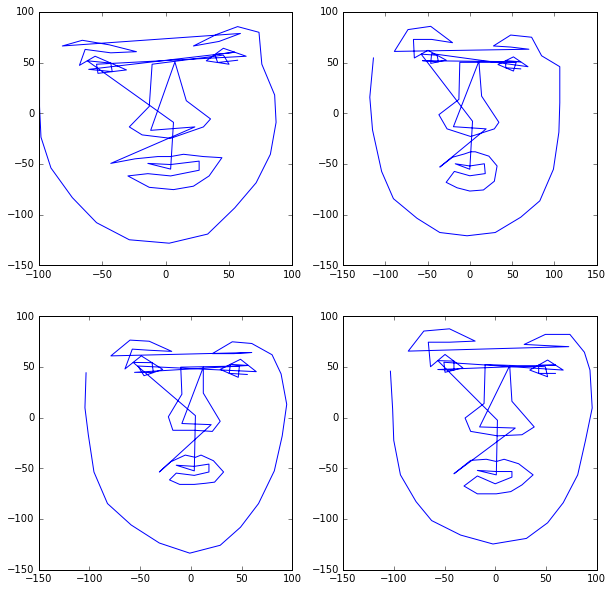

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.plot(X[0,:], Y[0,:])


plt.subplot(2, 2, 2)
plt.plot(X[100,:], Y[100,:])

plt.subplot(2, 2, 3)
plt.plot(X[200,:], Y[200,:])

plt.subplot(2, 2, 4)
plt.plot(X[300,:], Y[300,:])

plt.show()

### Compute the mean face

Now that the faces are aligned using scaling and linear translation, we compute the mean face.

(By the way, mean face here refers to the average face, not mean=angry! :))

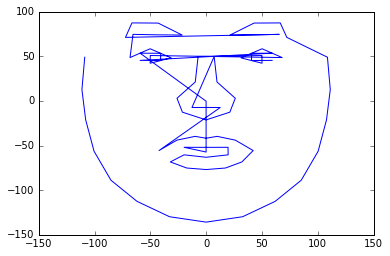

In [21]:
mean_face_x = np.mean(X, axis=0)
mean_face_y = np.mean(Y, axis=0)

plt.plot(mean_face_x, mean_face_y)
plt.show()

## Compute the eigne faces

We want to develop a model that by chaning its parameters, we can generate new faces. But, we can arbitralily apply some distortions to faces. 

In order to generate new faces, we can compute some vectors that have the highest variations among our current faces. Then, we can apply change the mean face along those faces which gives us a new face. This can be done by computing the eigen vevtors of the covariance matrix of these faces, also we call it "Eigen Faces".

### Covariance matrix of all faces


In [22]:
D = np.concatenate((X, Y), axis=1)
D.shape

(7510, 152)

In [23]:
cov_mat = np.cov(D.T)

cov_mat.shape

(152, 152)

### Eigen vectors and eigen values of covariance matrix

In [24]:
eig_values, eig_vectors = np.linalg.eig(cov_mat)

print(eig_values.shape, eig_vectors.shape)

(152,) (152, 152)


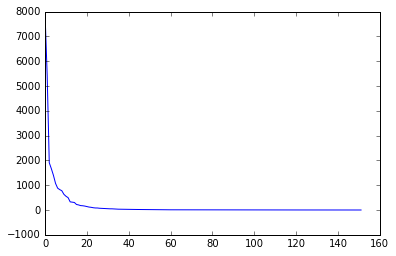

In [25]:
plt.plot(eig_values)

In [26]:
num_eigs = 20
Phi_matrix = eig_vectors[:,:num_eigs]

Phi_matrix.shape

(152, 20)

Finally, everything is ready to generate new faces. Applying a distortion along those eigen faces generates a new face according to the following formula:

$$\hat{r} = \bar{r} + \phi b$$

where $\hat{r}$ is the new face, $\bar{r}$ is the mean face, $\phi$ is the matrix of eigen values, and $b$ is the distortion parameter along each eigen vector. 

In [29]:
def construct_newface(meanface, Phi_matrix, b):
    face = meanface + np.dot(Phi_matrix, b )
    return (face[:76], face[76:])

For clarity, we generate distorion vectors of all zero values except one non-zero element. That non-zero element is a multiplication of the corresponding eigen-value times a small factor.

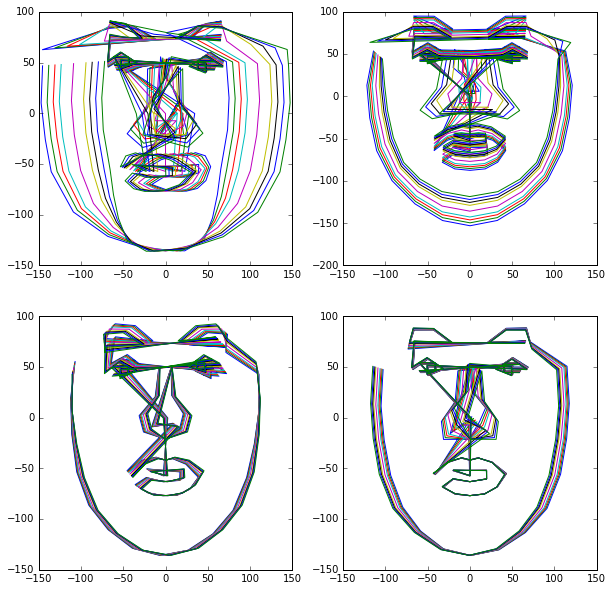

In [46]:
meanface = np.concatenate((mean_face_x, mean_face_y))

plt.figure(figsize=(10,10))


for i in range(4):
    plt.subplot(2, 2, i+1)
    b = np.zeros(shape=num_eigs)
    for j in (-0.025, -0.02, -0.015, -0.01, 0, 0.01, 0.015, 0.02, 0.025):
        b[i] = j*eig_values[i]
        xnew, ynew = construct_newface(meanface, Phi_matrix, b=b) 
                                  
        plt.plot(xnew, ynew)
    
plt.show()

## Conclusion

In this article, we used a dataset of dace landmarks and developed a model for generating new faces. First, we applied scaling and linear translation to align the faces together. Then, we computed the mean face ($\bar{r}$) and the matrix eigen vectors ($\phi$). Then, using ditortions along the first four eigen vector, we generated new faces.

In the new faces, distortions along the first eigen vector resulted in mostly changing the width of faces, while the second eigen vector changes the face height and the shape of nose.